energy-consumption

YouTube: https://www.youtube.com/watch?v=vV12dGe_Fho&t=56s

kaggle notebook: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb

from sklearn.metrics import mean_squared_error

C:\Users\lizma\anaconda3\envs\homl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('input/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)  # Cast Datetime from str obj to datetime

In [3]:
print(f'shape {df.shape}')
df.head()

shape (145366, 1)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


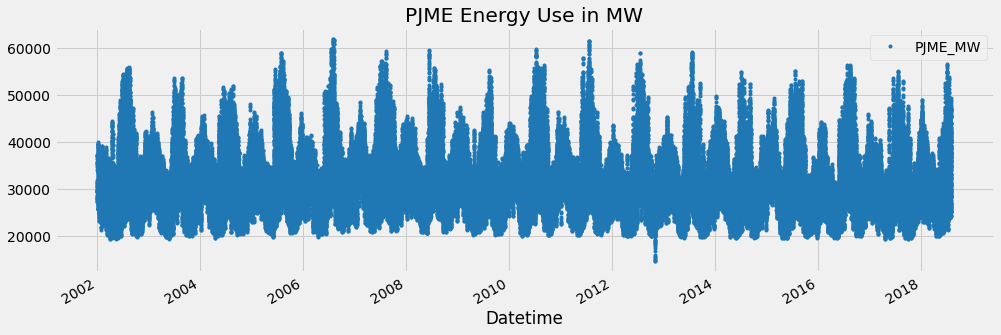

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

plt.show()

## Train /Test split

See another tutorial for full cross validation. For now, we'll do a split based on date = 01-01-2015

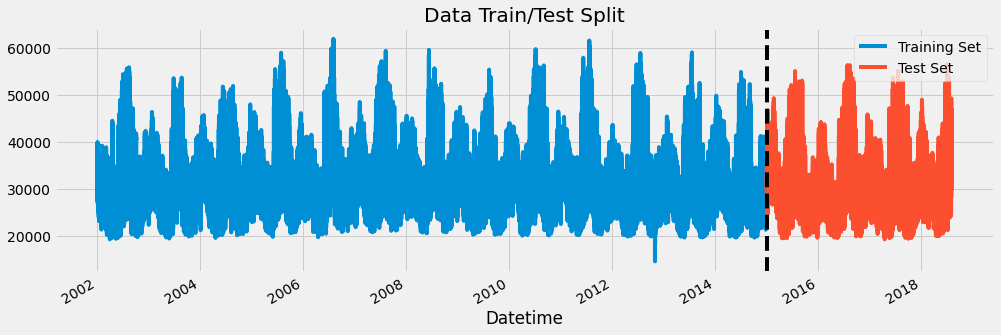

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot:xlabel='Datetime'>

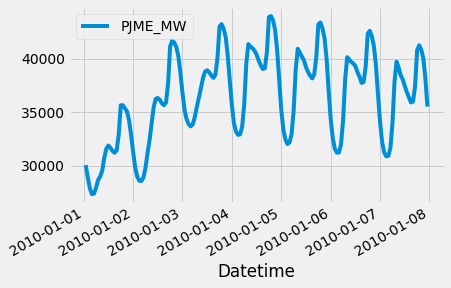

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot() # US month-day-year

## Create features

In [8]:
def create_features(df):
    """
    Create time series features based on df index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

In [9]:
df = create_features(df)

In [10]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


### Visualize feature / target relationship

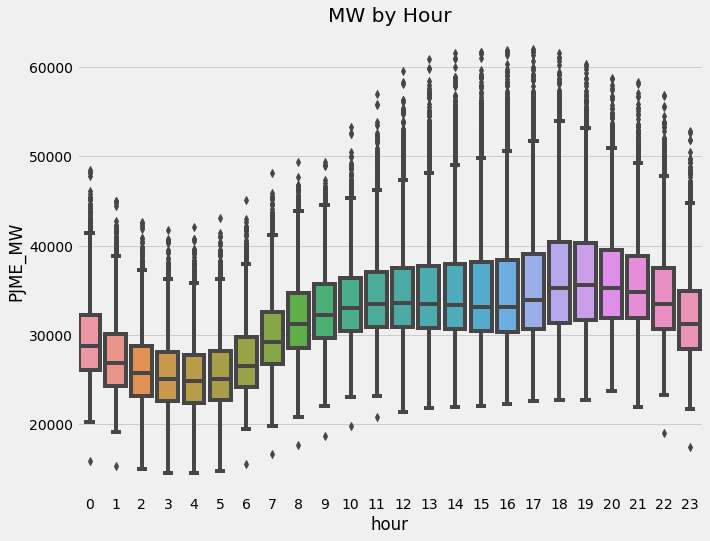

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

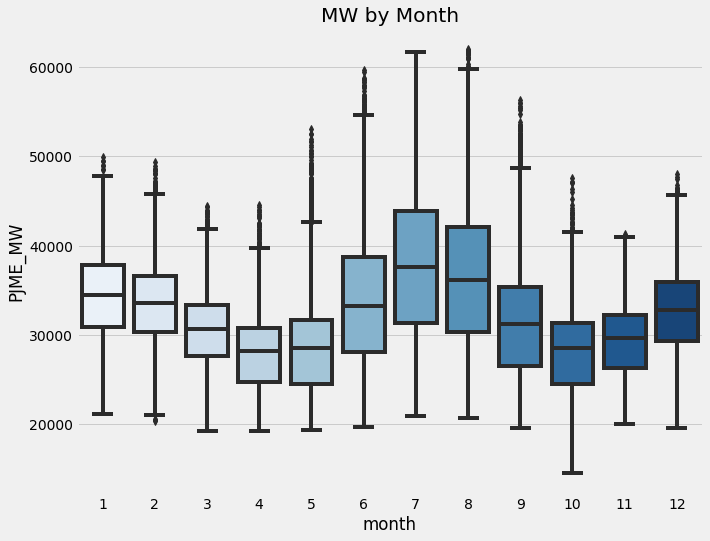

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

   ## Create model
   ***
   XGBoost is a robust machine-learning algorithm that can help you understand your data and make better decisions. XGBoost is an implementation of gradient-boosting decision trees.

In [13]:
# Run our train/test set through the create_features fn
train = create_features(train)
test = create_features(test)

# Define features
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

# Set target
TARGET = 'PJME_MW'

# Define features (x) and target (y) in train/test
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
# XGBoost regression model
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],  # Do evaluation on both train and test set for comparisons
#         verbose=True)

Error on val_1 starts to get worse, indicating overfitting. And it keeps going for 1000 trees despite the early stopping condition. I’ve seen in many places recommendation to use about 10% of total number of trees for early stopping. So, tweak the model a bit.

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],  # Do evaluation on both train and test set for comparisons
        verbose=100)

[18:52:58] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32601.86523	validation_1-rmse:31654.28320


C:\Users\lizma\anaconda3\envs\homl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12342.13672	validation_1-rmse:11517.66016
[200]	validation_0-rmse:5373.33203	validation_1-rmse:5165.30762
[300]	validation_0-rmse:3375.20557	validation_1-rmse:3829.29736
[400]	validation_0-rmse:2882.55054	validation_1-rmse:3715.26978
[500]	validation_0-rmse:2699.48853	validation_1-rmse:3756.51245
[600]	validation_0-rmse:2601.12451	validation_1-rmse:3806.29590
[700]	validation_0-rmse:2516.63892	validation_1-rmse:3845.61377
[800]	validation_0-rmse:2459.07251	validation_1-rmse:3873.98193
[900]	validation_0-rmse:2423.80591	validation_1-rmse:3897.27881
[999]	validation_0-rmse:2377.90625	validation_1-rmse:3935.06421


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Feature importance

In [16]:
reg.feature_importances_

array([0.1033883 , 0.36734486, 0.11250813, 0.04970842, 0.3422827 ,
       0.02476759], dtype=float32)

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,   #reg.feature_names_in_, gave an error
             columns=['importance'])

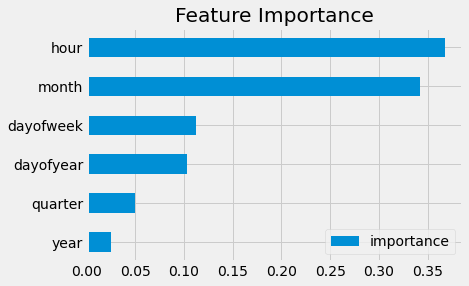

In [18]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Note that these features are interconnected so interpret above plot carefully.

## Forecast on test set with trained model

In [19]:
test["Predictions"] = reg.predict(X_test)

C:\Users\lizma\anaconda3\envs\homl\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [20]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,Predictions
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32197.501953
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,29810.025391
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,28648.300781
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,28032.685547
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,27975.332031


In [21]:
# Like table joins in DB
df = df.merge(test[['Predictions']], how='left', left_index=True, right_index=True)

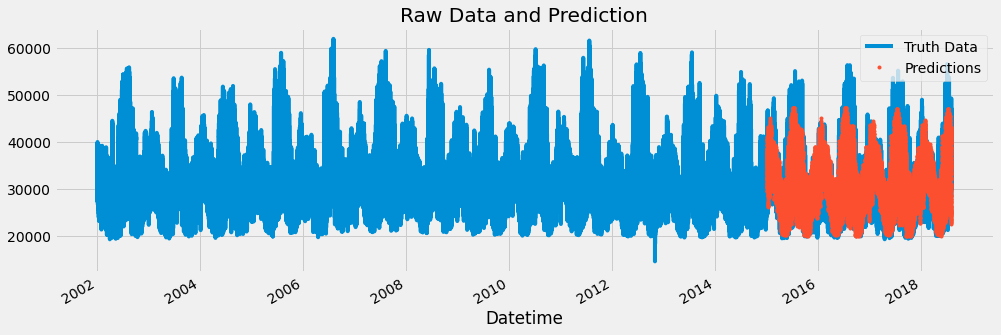

In [22]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['Predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

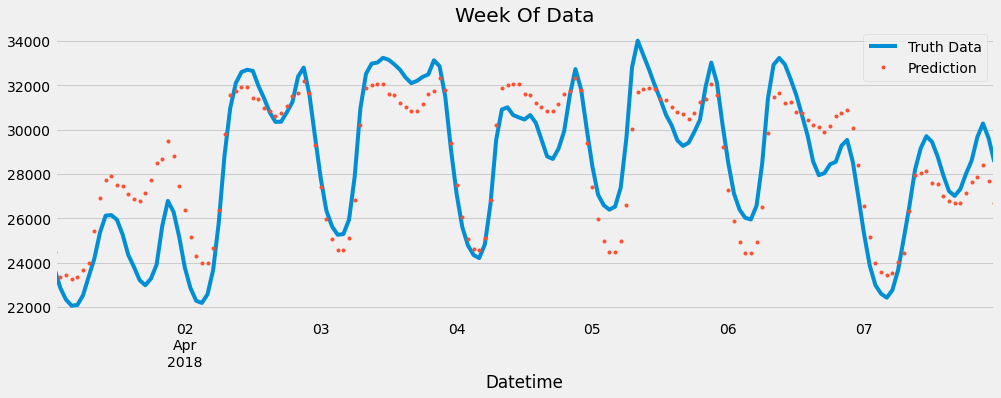

In [23]:
# Just one week
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['Predictions'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

It's not great - although better that the tutorial data. Could try parameter tuning - we didn't do any.

## Score = RMSE

In [24]:
# RMSE to compare with training numbers
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['Predictions']))  # pars = true value, prediction
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3935.07


## Error
- Look at best and worst predicted days

In [27]:
test["error"] = np.abs(test[TARGET] - test["Predictions"])

In [28]:
test['date'] = test.index.date

In [29]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,Predictions,error,date
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32197.501953,604.498047,2015-01-01
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,29810.025391,5505.025391,2015-12-31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,28648.300781,5492.300781,2015-12-31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,28032.685547,5518.685547,2015-12-31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,27975.332031,5645.332031,2015-12-31


In [33]:
# test.groupby(['date'])['error'].mean() # Average error for each day
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5) # sort them and look at top 5

date
2016-08-13    16180.623047
2016-08-14    16070.169922
2016-08-12    12503.694906
2016-09-10    12091.222819
2016-09-09    10864.320475
Name: error, dtype: float64

Worst predictions = biggest error

In [35]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5) # sort them and look at worst 5

date
2016-10-02    279.221436
2015-10-28    301.900228
2017-08-11    302.195882
2016-10-08    375.448161
2017-04-01    382.428385
Name: error, dtype: float64

Best predictions = smallest error

## Next steps
- More robust cross validation
- Add more features (weather forecast, holidays)